In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt import objective_functions

In [3]:
data_mmvb = pd.read_csv("C:/Users/bmw_7/Downloads/ListingSecurityList.csv", encoding = "windows-1251")
data_mmvb.tail()

,DATESTAMP,INSTRUMENT_ID,LIST_SECTION,RN,SUPERTYPE,INSTRUMENT_TYPE,INSTRUMENT_CATEGORY,TRADE_CODE,ISIN,REGISTRY_NUMBER,...,LISTING_LEVEL_HIST,OBLIGATION_PROGRAM_RN,COUPON_PERCENT,EARLY_REPAYMENT,EARLY_REDEMPTION,ISS_BOARDS,OTHER_SECURITIES,DISCLOSURE_PART_PAGE,DISCLOSURE_RF_INFO_PAGE,Unnamed: 39
2850,11.06.2020 0:00:00,244,Третий уровень,2851,Акции,Акция обыкновенная,акции обыкновенные,IRKT,RU0006752979,1-03-00040-A,...,09.06.2014 Включение в Третий уровень 08.08.20...,NaN,NaN,NaN,NaN,РПС : Акции РЕПО в ин. валюте: USD РЕПО c обли...,"Облигация биржевая, 4B02-04-00040-A, RU000A0JU...",http://www.irkut.com/,http://www.e-disclosure.ru/portal/company.aspx...,NaN
2851,11.06.2020 0:00:00,5274,Третий уровень,2852,Облигации,Облигация биржевая,документарные процентные неконвертируемые бирж...,RU000A0JUA45,RU000A0JUA45,4B02-04-00040-A,...,03.04.2020 Включение в Третий уровень 10.12.20...,NaN,9%,+,NaN,РПС : Облигации РЕПО c облигациями РЕПО с ЦК 1...,"Акция обыкновенная, 1-03-00040-A, RU0006752979...",http://www.irkut.com/,http://www.e-disclosure.ru/portal/company.aspx...,NaN
2852,11.06.2020 0:00:00,5275,Третий уровень,2853,Облигации,Облигация биржевая,документарные процентные неконвертируемые бирж...,NaN,NaN,4B02-05-00040-A,...,09.06.2014 Включение в Третий уровень 30.07.20...,NaN,NaN,+,NaN,NaN,"Акция обыкновенная, 1-03-00040-A, RU0006752979...",http://www.irkut.com/,http://www.e-disclosure.ru/portal/company.aspx...,NaN
2853,11.06.2020 0:00:00,5276,Третий уровень,2854,Облигации,Облигация биржевая,документарные процентные неконвертируемые бирж...,NaN,NaN,4B02-06-00040-A,...,09.06.2014 Включение в Третий уровень 30.07.20...,NaN,NaN,+,NaN,NaN,"Акция обыкновенная, 1-03-00040-A, RU0006752979...",http://www.irkut.com/,http://www.e-disclosure.ru/portal/company.aspx...,NaN
2854,11.06.2020 0:00:00,6055,Третий уровень,2855,Облигации,Облигация биржевая,Биржевые облигации документарные процентные не...,NaN,NaN,4B02-06-21927-H,...,06.10.2014 Включение в Третий уровень,NaN,NaN,+,NaN,NaN,"Акция обыкновенная, 1-03-00040-A, RU0006752979...",http://www.irkut.com/,http://www.e-disclosure.ru/portal/company.aspx...,NaN


In [4]:
stocks_mmvb = data_mmvb[data_mmvb.SUPERTYPE == "Акции"]
stocks_ao_mmvb = stocks_mmvb[stocks_mmvb.INSTRUMENT_TYPE == "Акция обыкновенная"]
fl_stocks_mmvb = stocks_ao_mmvb[stocks_ao_mmvb.LIST_SECTION == "Первый уровень"]
names = fl_stocks_mmvb.TRADE_CODE

In [5]:
names = [s + ".ME" for s in names] #Appropriate format for yf library
stocks_data = yf.download(names, period="max")

[*********************100%***********************]  40 of 40 completed


In [253]:
vol = stocks_data["Volume"]
vol = vol[vol.index >= "2015-01-01"]
norm_vol = vol[vol[vol.columns] >= 50000]
norm_vol.dropna(axis=1, thresh = (len(norm_vol)-100), inplace=True)
names = norm_vol.columns
names = [s for s in names]

['AFKS.ME',
 'AFLT.ME',
 'ALRS.ME',
 'CHMF.ME',
 'ENRU.ME',
 'FEES.ME',
 'GAZP.ME',
 'GMKN.ME',
 'HYDR.ME',
 'IRAO.ME',
 'LKOH.ME',
 'MAGN.ME',
 'MGNT.ME',
 'MOEX.ME',
 'MSNG.ME',
 'MTLR.ME',
 'MTSS.ME',
 'NLMK.ME',
 'NVTK.ME',
 'ROSN.ME',
 'RSTI.ME',
 'RTKM.ME',
 'SBER.ME',
 'TATN.ME',
 'TGKA.ME',
 'TRMK.ME',
 'UPRO.ME',
 'VTBR.ME']

In [254]:
stocks_data = yf.download(names, period="max")

[*********************100%***********************]  28 of 28 completed


In [383]:
close_prices = stocks_data["Adj Close"]
close_prices = close_prices[close_prices.index >= "2012-01-01"]
close_prices.tail()

,AFKS.ME,AFLT.ME,ALRS.ME,CHMF.ME,ENRU.ME,FEES.ME,GAZP.ME,GMKN.ME,HYDR.ME,IRAO.ME,...,NVTK.ME,ROSN.ME,RSTI.ME,RTKM.ME,SBER.ME,TATN.ME,TGKA.ME,TRMK.ME,UPRO.ME,VTBR.ME
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-05,16.941000,89.800003,65.050003,949.000000,0.9920,0.1838,203.050003,20400.0,0.7414,5.0450,...,1086.400024,383.805511,1.519831,84.900002,219.100006,569.900024,0.01300,59.759998,2.778,0.03760
2020-06-08,16.947001,95.699997,66.500000,944.000000,0.9955,0.1840,204.910004,20502.0,0.7888,5.1350,...,1080.000000,382.086761,1.487095,84.199997,220.300003,578.400024,0.01304,59.959999,2.808,0.03770
2020-06-09,16.943001,92.400002,65.279999,948.000000,0.9970,0.1820,204.839996,20248.0,0.7799,5.0410,...,1078.000000,383.853241,1.462283,84.900002,217.229996,586.500000,0.01300,59.900002,2.810,0.03770
2020-06-10,16.742001,89.279999,64.150002,950.400024,0.9950,0.1880,201.750000,20240.0,0.7930,4.9700,...,1092.000000,382.229980,1.475585,84.980003,212.529999,595.900024,0.01301,59.740002,2.796,0.03758
2020-06-11,16.110001,87.699997,62.950001,939.000000,0.9825,0.1855,196.740005,19482.0,0.7800,4.8435,...,1068.400024,376.100006,1.461600,84.000000,208.350006,577.000000,0.01288,59.860001,2.733,0.03675


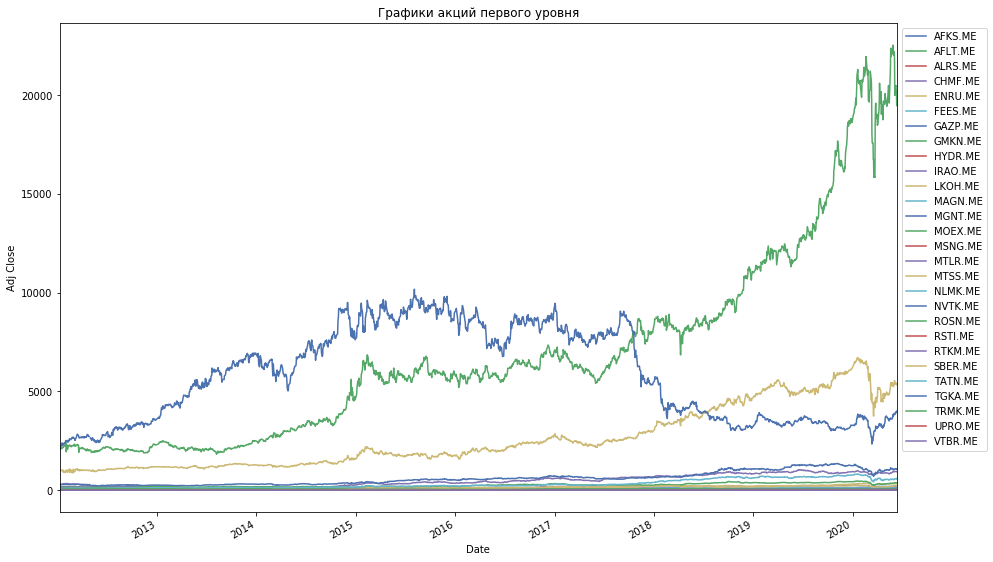

In [429]:
close_prices.plot(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Графики акций первого уровня')
plt.legend(bbox_to_anchor=(1, 1))

In [385]:
sample_cov_matr = risk_models.sample_cov(close_prices, frequency=252)
sample_cov_matr

,AFKS.ME,AFLT.ME,ALRS.ME,CHMF.ME,ENRU.ME,FEES.ME,GAZP.ME,GMKN.ME,HYDR.ME,IRAO.ME,...,NVTK.ME,ROSN.ME,RSTI.ME,RTKM.ME,SBER.ME,TATN.ME,TGKA.ME,TRMK.ME,UPRO.ME,VTBR.ME
AFKS.ME,0.326015,0.036978,0.019036,0.019118,0.031626,0.052343,0.035287,0.032036,0.048413,0.044455,...,0.043311,0.031251,0.057188,0.027924,0.039143,0.046428,0.037181,0.028610,0.032011,0.029014
AFLT.ME,0.036978,0.116416,0.026723,0.020982,0.022050,0.045890,0.028734,0.018796,0.033426,0.039073,...,0.030204,0.027037,0.053629,0.020505,0.039030,0.029264,0.036865,0.029255,0.022387,0.029556
ALRS.ME,0.019036,0.026723,0.096246,0.019851,0.013952,0.025654,0.023460,0.019247,0.022163,0.023135,...,0.029407,0.023440,0.025547,0.016654,0.025045,0.026848,0.020540,0.014019,0.014020,0.023932
CHMF.ME,0.019118,0.020982,0.019851,0.105747,0.014540,0.031338,0.026645,0.034505,0.026919,0.027161,...,0.035034,0.023777,0.041317,0.020160,0.028904,0.039709,0.025497,0.022243,0.019633,0.031069
ENRU.ME,0.031626,0.022050,0.013952,0.014540,0.083887,0.033185,0.018546,0.011202,0.024912,0.025157,...,0.019891,0.016791,0.035781,0.014533,0.028746,0.018230,0.024723,0.016956,0.016467,0.019688
FEES.ME,0.052343,0.045890,0.025654,0.031338,0.033185,0.158268,0.037903,0.023825,0.061211,0.067320,...,0.038142,0.033425,0.120189,0.030537,0.052303,0.039095,0.054142,0.035585,0.033853,0.041323
GAZP.ME,0.035287,0.028734,0.023460,0.026645,0.018546,0.037903,0.107852,0.031238,0.031440,0.025224,...,0.036005,0.038174,0.049879,0.025273,0.092324,0.040605,0.028888,0.026835,0.022293,0.029905
GMKN.ME,0.032036,0.018796,0.019247,0.034505,0.011202,0.023825,0.031238,0.095843,0.017928,0.020082,...,0.035516,0.027923,0.029377,0.020102,0.021595,0.039051,0.022034,0.018646,0.018531,0.020939
HYDR.ME,0.048413,0.033426,0.022163,0.026919,0.024912,0.061211,0.031440,0.017928,0.112394,0.040978,...,0.032265,0.033154,0.062805,0.026914,0.047304,0.038236,0.039750,0.031762,0.027300,0.033986
IRAO.ME,0.044455,0.039073,0.023135,0.027161,0.025157,0.067320,0.025224,0.020082,0.040978,0.139943,...,0.034154,0.028981,0.065801,0.023802,0.040476,0.034788,0.038909,0.029014,0.028784,0.028765


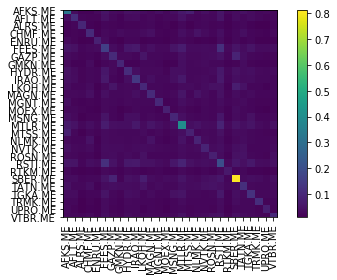

In [430]:
from pypfopt import plotting
plotting.plot_covariance(sample_cov_matr);

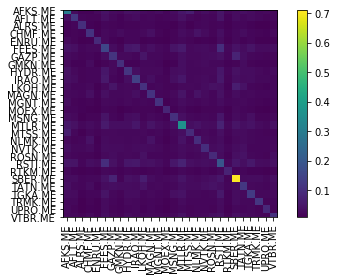

In [431]:
S = risk_models.CovarianceShrinkage(close_prices).ledoit_wolf()
plotting.plot_covariance(S);

In [388]:
mu = expected_returns.capm_return(close_prices)
mu

AFKS.ME    0.205711
AFLT.ME    0.148920
ALRS.ME    0.113674
CHMF.ME    0.139514
ENRU.ME    0.108076
FEES.ME    0.203932
GAZP.ME    0.160293
GMKN.ME    0.125300
HYDR.ME    0.162976
IRAO.ME    0.168806
LKOH.ME    0.155745
MAGN.ME    0.154342
MGNT.ME    0.135603
MOEX.ME    0.120133
MSNG.ME    0.147472
MTLR.ME    0.241257
MTSS.ME    0.144033
NLMK.ME    0.146029
NVTK.ME    0.154503
ROSN.ME    0.144489
RSTI.ME    0.229770
RTKM.ME    0.111731
SBER.ME    0.285203
TATN.ME    0.168089
TGKA.ME    0.158528
TRMK.ME    0.132161
UPRO.ME    0.117961
VTBR.ME    0.148834
Name: mkt, dtype: float64

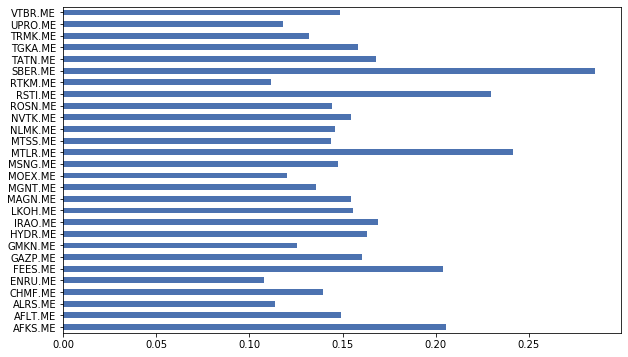

In [389]:
mu.plot.barh(figsize=(10,6));

In [435]:
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AFKS.ME', 0.0),
             ('AFLT.ME', 0.0235),
             ('ALRS.ME', 0.08549),
             ('CHMF.ME', 0.04164),
             ('ENRU.ME', 0.11508),
             ('FEES.ME', 0.0),
             ('GAZP.ME', 0.00887),
             ('GMKN.ME', 0.06999),
             ('HYDR.ME', 0.0019),
             ('IRAO.ME', 0.00124),
             ('LKOH.ME', 0.02282),
             ('MAGN.ME', 0.00827),
             ('MGNT.ME', 0.04513),
             ('MOEX.ME', 0.12576),
             ('MSNG.ME', 0.04421),
             ('MTLR.ME', 0.0),
             ('MTSS.ME', 0.03876),
             ('NLMK.ME', 0.02656),
             ('NVTK.ME', 0.0),
             ('ROSN.ME', 0.03584),
             ('RSTI.ME', 0.0),
             ('RTKM.ME', 0.11767),
             ('SBER.ME', 0.0),
             ('TATN.ME', 0.0),
             ('TGKA.ME', 0.01141),
             ('TRMK.ME', 0.05412),
             ('UPRO.ME', 0.10044),
             ('VTBR.ME', 0.02131)])

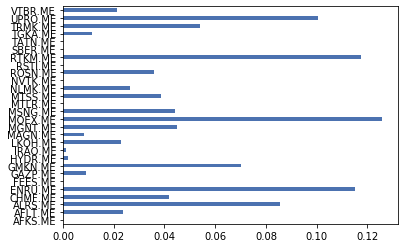

In [436]:
pd.Series(weights).plot.barh();

In [437]:
ef.portfolio_performance(verbose=True);

Expected annual return: 12.7%
Annual volatility: 15.1%
Sharpe Ratio: 0.70


Text(0, 0.5, '')

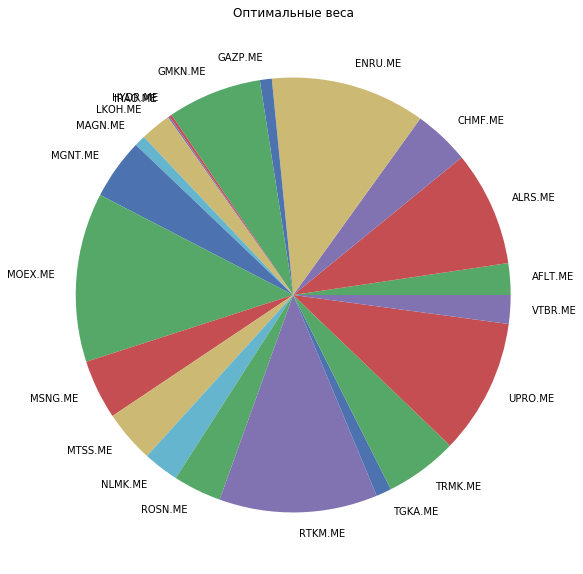

In [438]:
pd.Series(weights).plot.pie(figsize=(10, 10))
plt.title('Оптимальные веса')
plt.ylabel('')

In [439]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

7/28 tickers have zero weight


In [442]:
#L2 регуляризация с параметром 0.1
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.2)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AFKS.ME', 0.00985),
             ('AFLT.ME', 0.03786),
             ('ALRS.ME', 0.05842),
             ('CHMF.ME', 0.0415),
             ('ENRU.ME', 0.06681),
             ('FEES.ME', 0.00806),
             ('GAZP.ME', 0.03278),
             ('GMKN.ME', 0.05181),
             ('HYDR.ME', 0.02974),
             ('IRAO.ME', 0.02761),
             ('LKOH.ME', 0.03428),
             ('MAGN.ME', 0.03299),
             ('MGNT.ME', 0.04508),
             ('MOEX.ME', 0.06728),
             ('MSNG.ME', 0.04149),
             ('MTLR.ME', 0.0012),
             ('MTSS.ME', 0.04278),
             ('NLMK.ME', 0.0377),
             ('NVTK.ME', 0.02971),
             ('ROSN.ME', 0.03938),
             ('RSTI.ME', 0.0),
             ('RTKM.ME', 0.06385),
             ('SBER.ME', 0.00299),
             ('TATN.ME', 0.01958),
             ('TGKA.ME', 0.03268),
             ('TRMK.ME', 0.04776),
             ('UPRO.ME', 0.05945),
             ('VTBR.ME', 0.03735)])

In [443]:
# Число нулевых значений уменьшилось (7 -> 4)
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

1/28 tickers have zero weight


Text(0, 0.5, '')

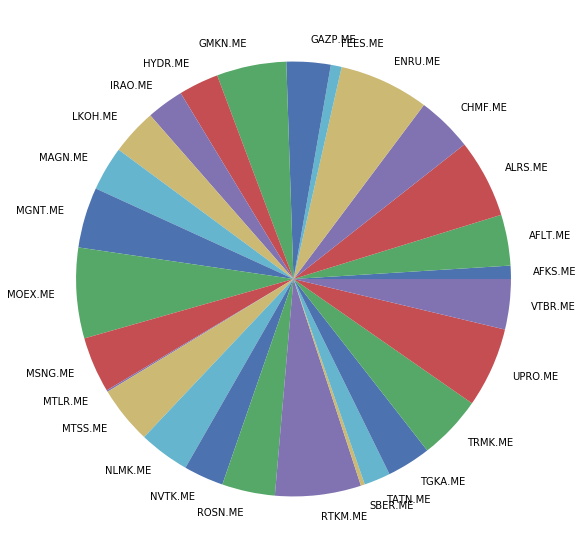

In [446]:
# Портфель стал более диверсифицированным
pd.Series(weights).plot.pie(figsize=(10, 10))
plt.ylabel('')

In [447]:
ef.portfolio_performance(verbose=True);

Expected annual return: 13.9%
Annual volatility: 15.7%
Sharpe Ratio: 0.75


In [448]:
# Определение L1 нормы
def L1_norm(w, k):
    return k * cp.norm(w, 1)

In [452]:
ef = EfficientFrontier(mu, S)
ef.add_objective(L1_norm, k=1000)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AFKS.ME', 0.00526),
             ('AFLT.ME', 0.03821),
             ('ALRS.ME', 0.06054),
             ('CHMF.ME', 0.0425),
             ('ENRU.ME', 0.06793),
             ('FEES.ME', 0.00459),
             ('GAZP.ME', 0.03261),
             ('GMKN.ME', 0.05299),
             ('HYDR.ME', 0.02919),
             ('IRAO.ME', 0.02629),
             ('LKOH.ME', 0.03423),
             ('MAGN.ME', 0.03346),
             ('MGNT.ME', 0.04618),
             ('MOEX.ME', 0.06822),
             ('MSNG.ME', 0.04095),
             ('MTLR.ME', 0.0),
             ('MTSS.ME', 0.04268),
             ('NLMK.ME', 0.0385),
             ('NVTK.ME', 0.03106),
             ('ROSN.ME', 0.04),
             ('RSTI.ME', 0.0),
             ('RTKM.ME', 0.0647),
             ('SBER.ME', 0.0),
             ('TATN.ME', 0.02042),
             ('TGKA.ME', 0.03235),
             ('TRMK.ME', 0.04902),
             ('UPRO.ME', 0.06026),
             ('VTBR.ME', 0.03783)])

In [453]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/28 tickers have zero weight


Text(0, 0.5, '')

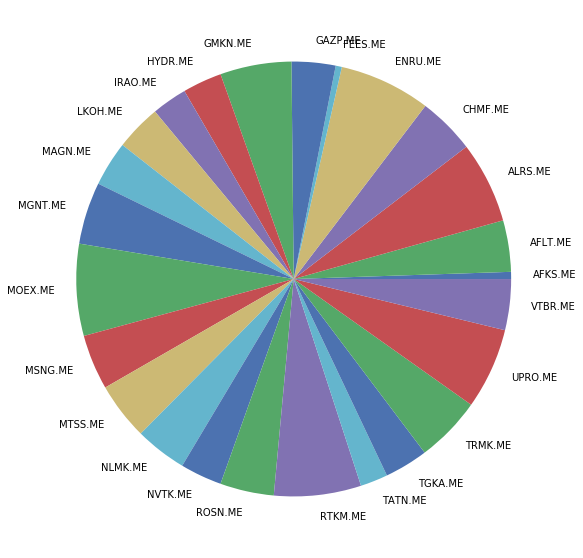

In [456]:
pd.Series(weights).plot.pie(figsize=(10, 10))
plt.ylabel('')

In [455]:
ef.portfolio_performance(verbose=True);

Expected annual return: 13.7%
Annual volatility: 15.7%
Sharpe Ratio: 0.75


In [462]:
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.efficient_return(target_return=0.12)
weights = ef.clean_weights()
weights

OrderedDict([('AFKS.ME', -0.01088),
             ('AFLT.ME', 0.032),
             ('ALRS.ME', 0.08122),
             ('CHMF.ME', 0.04435),
             ('ENRU.ME', 0.11504),
             ('FEES.ME', -0.018),
             ('GAZP.ME', 0.02063),
             ('GMKN.ME', 0.07245),
             ('HYDR.ME', 0.01745),
             ('IRAO.ME', 0.01708),
             ('LKOH.ME', 0.03141),
             ('MAGN.ME', 0.01501),
             ('MGNT.ME', 0.04851),
             ('MOEX.ME', 0.1248),
             ('MSNG.ME', 0.05538),
             ('MTLR.ME', -0.01287),
             ('MTSS.ME', 0.05213),
             ('NLMK.ME', 0.03048),
             ('NVTK.ME', -0.00479),
             ('ROSN.ME', 0.03963),
             ('RSTI.ME', -0.0425),
             ('RTKM.ME', 0.11529),
             ('SBER.ME', -0.00485),
             ('TATN.ME', -0.02681),
             ('TGKA.ME', 0.0228),
             ('TRMK.ME', 0.0547),
             ('UPRO.ME', 0.09966),
             ('VTBR.ME', 0.03067)])

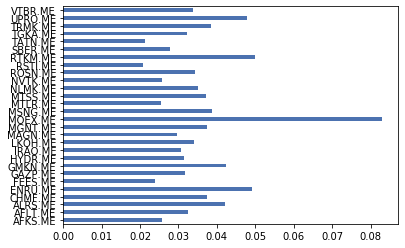

In [458]:
pd.Series(weights).plot.barh();

Text(0, 0.5, '')

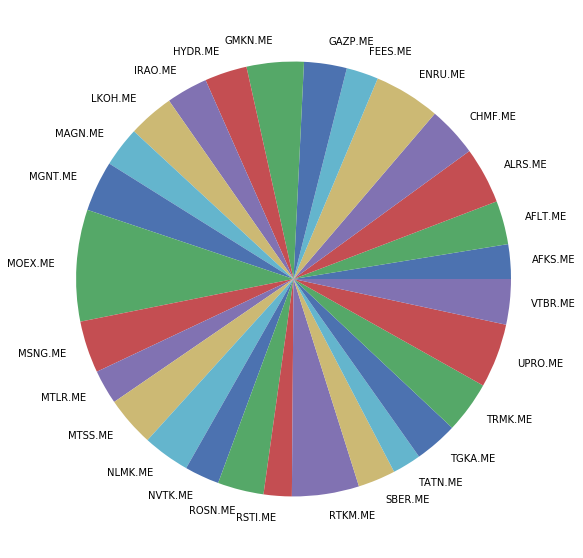

In [459]:
pd.Series(weights).plot.pie(figsize=(10, 10))
plt.ylabel('')

In [463]:
ef.portfolio_performance(verbose=True);

Expected annual return: 12.0%
Annual volatility: 14.9%
Sharpe Ratio: 0.67


In [428]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

0/28 tickers have zero weight


In [468]:
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.efficient_return(target_return=0.12)
ef.add_objective(objective_functions.L2_reg, gamma=0.2)
weights = ef.clean_weights()
weights

OrderedDict([('AFKS.ME', -0.01088),
             ('AFLT.ME', 0.032),
             ('ALRS.ME', 0.08122),
             ('CHMF.ME', 0.04435),
             ('ENRU.ME', 0.11504),
             ('FEES.ME', -0.018),
             ('GAZP.ME', 0.02063),
             ('GMKN.ME', 0.07245),
             ('HYDR.ME', 0.01745),
             ('IRAO.ME', 0.01708),
             ('LKOH.ME', 0.03141),
             ('MAGN.ME', 0.01501),
             ('MGNT.ME', 0.04851),
             ('MOEX.ME', 0.1248),
             ('MSNG.ME', 0.05538),
             ('MTLR.ME', -0.01287),
             ('MTSS.ME', 0.05213),
             ('NLMK.ME', 0.03048),
             ('NVTK.ME', -0.00479),
             ('ROSN.ME', 0.03963),
             ('RSTI.ME', -0.0425),
             ('RTKM.ME', 0.11529),
             ('SBER.ME', -0.00485),
             ('TATN.ME', -0.02681),
             ('TGKA.ME', 0.0228),
             ('TRMK.ME', 0.0547),
             ('UPRO.ME', 0.09966),
             ('VTBR.ME', 0.03067)])

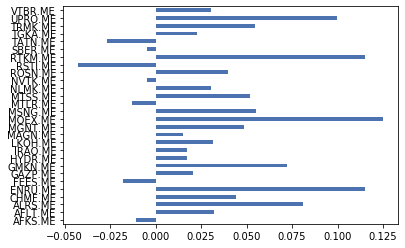

In [469]:
pd.Series(weights).plot.barh();

In [470]:
ef.portfolio_performance(verbose=True);

Expected annual return: 12.0%
Annual volatility: 14.9%
Sharpe Ratio: 0.67
